In [235]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

## Prepare Data

In [236]:
file_path = '../data/dgidb/embeddings/'

emd = 'metapath2vec_'
#emd = 'node2vec_'
#emd = 'struc2vec_'
#emd = 'deepwalk_'
#emd = 'word2vec_'
#emd = 'bine_'

drug_emd = pd.read_csv(file_path+emd+'drug_embeddings.csv', header=None, index_col=0).dropna(axis=1)
gene_emd = pd.read_csv(file_path+emd+'gene_embeddings.csv', header=None, index_col=0).dropna(axis=1)

In [237]:
tt_path = '../data/dgidb/train_test/'

#ns = '/uniform'
#ns = '/feature'
ns = '/topology'

train_edge = pd.read_csv(tt_path+emd[:-1]+ns+"/train.csv")
test_edge = pd.read_csv(tt_path+emd[:-1]+ns+"/test.csv")

In [238]:
drug_emd = drug_emd.rename_axis('drug')
gene_emd = gene_emd.rename_axis('gene')

In [239]:
merged_df_1 = pd.merge(train_edge, drug_emd, on='drug')
final_merged_df = pd.merge(merged_df_1, gene_emd, on='gene')
train_df = final_merged_df.drop(['drug', 'gene'], axis=1)

merged_df_1 = pd.merge(test_edge, drug_emd, on='drug')
final_merged_df = pd.merge(merged_df_1, gene_emd, on='gene')
test_df = final_merged_df.drop(['drug', 'gene'], axis=1)

In [240]:
X_train = train_df.drop('label', axis=1).dropna(axis=1)
y_train = train_df['label']

X_test = test_df.drop('label', axis=1).dropna(axis=1)
y_test = test_df['label']

X_train

## PCA

In [241]:
n_components = 128
 
pca = PCA(n_components=n_components)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("PCA Explained Variance: ", sum(pca.explained_variance_ratio_[:n_components]))

PCA Explained Variance:  0.882343034977183


## Logistic Regression

### Train & Predict

In [242]:
clf = LogisticRegression()
clf.fit(X_train_pca, y_train)

# Predict and evaluate the model
y_pred = clf.predict(X_test_pca)

### Evaluation

In [243]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import os

res_path = '../res/lr/' + emd[:-1] + ns 
os.makedirs(res_path, exist_ok=True)

In [244]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision_scr = precision_score(y_test, y_pred)
recall_scr = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [245]:
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_pca)[:,1])
roc_auc = auc(fpr, tpr)
roc_df = pd.DataFrame ({'fpr':fpr, 'tpr':tpr, '_':_})
roc_df.to_csv(res_path+'/roc.csv', index=None)

precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test_pca)[:,1])
pr_auc = auc(recall, precision)
prc_df = pd.DataFrame({'precision':precision,'recall':recall})
prc_df.to_csv(res_path+'/prc.csv', index=None)

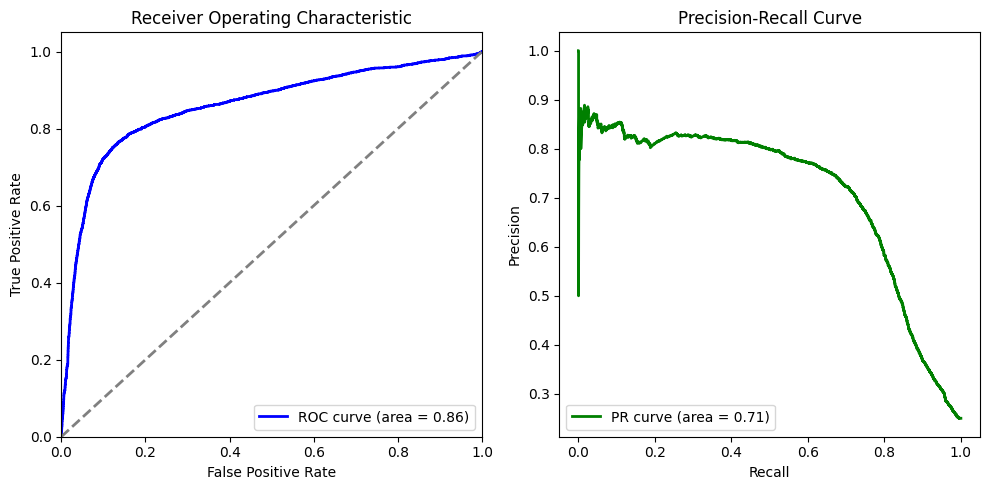

In [246]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Save the plots to a file
plt.tight_layout()

plots_file_path = res_path + '/plot.png'
plt.savefig(plots_file_path)
plt.show()


In [247]:
# Save the metrics to a file
metrics = {
    'Accuracy': accuracy,
    'Precision': precision_scr,
    'Recall': recall_scr,
    'F1 Score': f1,
    'AUROC': auc(fpr, tpr),
    'AUPRC': auc(recall, precision)
}
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
metrics_file_path = res_path + '/metrics.csv'
metrics_df.to_csv(metrics_file_path)